In [1]:
#pip install imblearn

# Extract Dataset

In [2]:
# import zipfile
# import os

# # 定义压缩包路径和目标文件夹路径
# zip_file_path = 'archive.zip'
# extract_folder_path = r'archive'

# # 创建目标文件夹（如果不存在）
# os.makedirs(extract_folder_path, exist_ok=True)

# # 解压缩压缩包
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_folder_path)

# print(f"Successfully extracted to {extract_folder_path}")

# Improt library

In [3]:
import os
import time
import shutil
import itertools

# import data handling tools 
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization,Multiply,Add,GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import categorical_crossentropy

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

2023-12-24 16:57:13.045975: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-24 16:57:13.241057: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


modules loaded


# Read CSV File

In [4]:
data_dir = r'archive/hmnist_28_28_RGB.csv'
data = pd.read_csv(data_dir)
data.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Columns: 2353 entries, pixel0000 to label
dtypes: int64(2353)
memory usage: 179.8 MB


In [6]:
Label = data["label"]
Data = data.drop(columns=["label"])

In [7]:
data["label"].value_counts()

label
4    6705
6    1113
2    1099
1     514
0     327
5     142
3     115
Name: count, dtype: int64

In [8]:
from imblearn.over_sampling import RandomOverSampler 

oversample = RandomOverSampler()
Data, Label  = oversample.fit_resample(Data, Label)
Data = np.array(Data).reshape(-1, 28, 28, 3)
print('Shape of Data :', Data.shape)

Shape of Data : (46935, 28, 28, 3)


In [9]:
Label = np.array(Label)
Label

array([2, 2, 2, ..., 6, 6, 6])

# Set Classes

In [10]:
classes = {4: ('nv', ' melanocytic nevi'),
           6: ('mel', 'melanoma'),
           2: ('bkl', 'benign keratosis-like lesions'), 
           1:('bcc' , ' basal cell carcinoma'),
           5: ('vasc', ' pyogenic granulomas and hemorrhage'),
           0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),
           3: ('df', 'dermatofibroma')}

In [11]:
from sklearn.model_selection import train_test_split

X_train , X_test , y_train , y_test = train_test_split(Data , Label , test_size = 0.25 , random_state = 49)

In [12]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(35201, 28, 28, 3)
(35201,)
(11734, 28, 28, 3)
(11734,)


In [13]:
from tensorflow.python.keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Data Augmentation

In [14]:


datagen = ImageDataGenerator(rescale=(1./255)
                             ,rotation_range=10
                             ,zoom_range = 0.1
                             ,width_shift_range=0.1
                             ,height_shift_range=0.1)

testgen = ImageDataGenerator(rescale=(1./255))

In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Concatenate, Flatten, Dense

def squeeze_excitation_block(x, ratio=8):
    channels = int(x.shape[-1])
    se = GlobalAveragePooling2D()(x)
    se = Dense(channels // ratio, activation='relu')(se)
    se = Dense(channels, activation='sigmoid')(se)
    se = tf.keras.layers.Reshape((1, 1, channels))(se)
    scaled = Multiply()([x, se])
    return scaled

def inception_block(x, filters):
    conv1x1 = Conv2D(filters[0], (1, 1), padding='same', activation='relu')(x)

    conv3x3 = Conv2D(filters[1], (1, 1), padding='same', activation='relu')(x)
    conv3x3 = Conv2D(filters[2], (3, 3), padding='same', activation='relu')(conv3x3)

    conv5x5 = Conv2D(filters[3], (1, 1), padding='same', activation='relu')(x)
    conv5x5 = Conv2D(filters[4], (5, 5), padding='same', activation='relu')(conv5x5)

    maxpool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    maxpool = Conv2D(filters[5], (1, 1), padding='same', activation='relu')(maxpool)

    inception_block = Concatenate(axis=-1)([conv1x1, conv3x3, conv5x5, maxpool])
    return inception_block

def inception_net(input_shape, num_classes):
    input_tensor = Input(shape=input_shape)

    # Initial convolutional layer
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(input_tensor)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Inception blocks
    x = inception_block(x, filters=[64, 128, 128, 32, 32, 32])
    x = inception_block(x, filters=[128, 192, 192, 64, 64, 64])
            # Attention mechanism
    x = squeeze_excitation_block(x)

    # MaxPooling and Fully Connected layers
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=input_tensor, outputs=x)

    return model




In [16]:
# Set input shape and number of classes
input_shape = (28, 28, 3)  # Example input shape, adjust based on your requirements
num_classes = 7  # Adjust based on your classification task

# Create the depthwise separable CNN model
model = inception_net(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

2023-12-24 16:57:22.713585: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-24 16:57:23.377682: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22292 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:03:00.0, compute capability: 8.6


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 64)   9472        ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 7, 7, 64)     0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 7, 7, 128)    8320        ['max_pooling2d[0][0]']          
                                                                                              

# Data Augmentation

In [17]:
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy'
                                            , patience = 2
                                            , verbose=1
                                            ,factor=0.5
                                            , min_lr=0.00001)

# Fit the model

In [18]:
from tensorflow.keras.callbacks import EarlyStopping
history = model.fit(X_train ,
                    y_train ,
                    epochs=250,
                    batch_size=128,
                    validation_data=(X_test , y_test) ,
                    callbacks=[learning_rate_reduction,EarlyStopping(monitor='loss', patience=5, restore_best_weights = True)])

2023-12-24 16:57:24.304774: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 662342016 exceeds 10% of free system memory.
2023-12-24 16:57:24.858952: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 662342016 exceeds 10% of free system memory.


Epoch 1/250


2023-12-24 16:57:27.532211: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2023-12-24 16:57:29.059857: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


276/276 [==============================] - 9s 18ms/step - loss: 3.1758 - accuracy: 0.4855 - val_loss: 2.8490 - val_accuracy: 0.2596 - lr: 0.0010
Epoch 2/250
276/276 [==============================] - 4s 15ms/step - loss: 1.3659 - accuracy: 0.5025 - val_loss: 3.8421 - val_accuracy: 0.1570 - lr: 0.0010
Epoch 3/250
276/276 [==============================] - 4s 15ms/step - loss: 1.1151 - accuracy: 0.5815 - val_loss: 1.1273 - val_accuracy: 0.5774 - lr: 0.0010
Epoch 4/250
276/276 [==============================] - 4s 14ms/step - loss: 0.7968 - accuracy: 0.7018 - val_loss: 0.8562 - val_accuracy: 0.6850 - lr: 0.0010
Epoch 5/250
276/276 [==============================] - 4s 15ms/step - loss: 0.6039 - accuracy: 0.7761 - val_loss: 6.8254 - val_accuracy: 0.2854 - lr: 0.0010
Epoch 6/250
272/276 [============================>.] - ETA: 0s - loss: 1.4388 - accuracy: 0.5089
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
276/276 [==============================] - 4s 15ms/ste

# Grad-CAM (Gradient-weighted Class Activation Mapping)

In [19]:
def preprocess_input(x):
    return x / 255.0

In [20]:
# Set input shape and number of classes
input_shape = (224, 224, 3)  # Example input shape, adjust based on your requirements
num_classes = 7  # Adjust based on your classification task

# Create the depthwise separable CNN model
model2 = inception_net(input_shape, num_classes)

# Compile the model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# model2.summary()

In [21]:
# last_conv_layer_name = [layer.name for layer in model2.layers if 'conv' in layer.name][-1]
# last_conv_layer = model.get_layer(last_conv_layer_name)

1/1 [==============================] - 0s 372ms/step


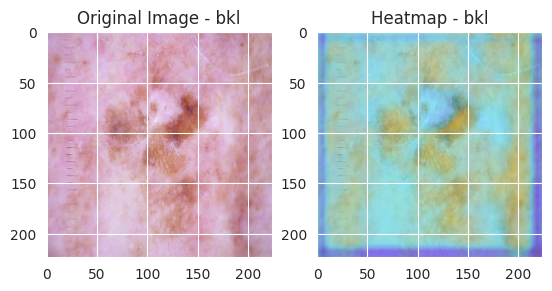

1/1 [==============================] - 0s 28ms/step


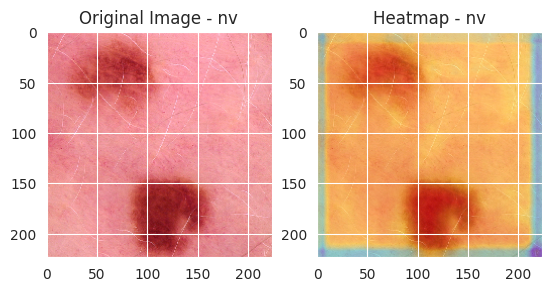

1/1 [==============================] - 0s 28ms/step


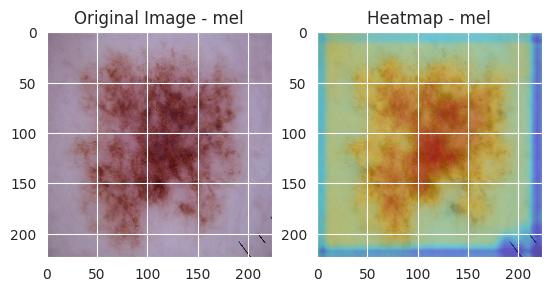

1/1 [==============================] - 0s 28ms/step


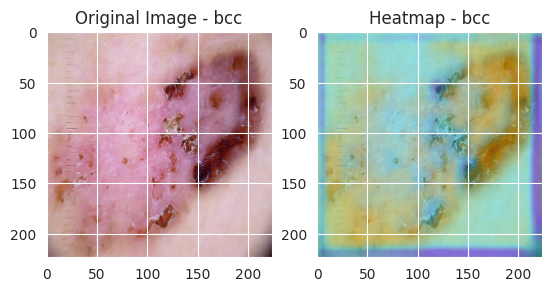

1/1 [==============================] - 0s 28ms/step


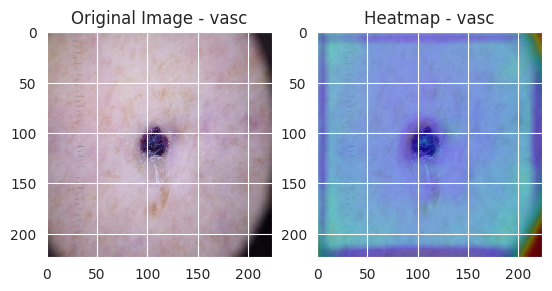

1/1 [==============================] - 0s 27ms/step


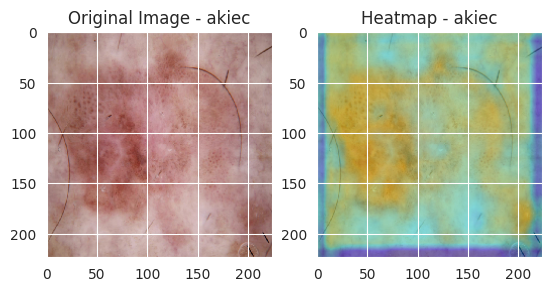

1/1 [==============================] - 0s 27ms/step


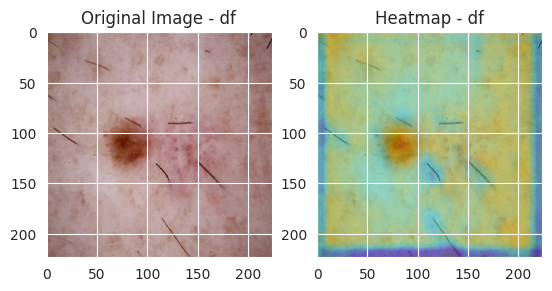

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import tensorflow as tf

# 假设你的数据集是一个字典，其中键是类别，值是图像路径的列表
dataset = {
    'bkl': ['archive/HAM10000_images_part_1/ISIC_0027419.jpg'],
    'nv': ['archive/HAM10000_images_part_1/ISIC_0028239.jpg'],
    'mel': ['archive/HAM10000_images_part_1/ISIC_0027190.jpg'],
    'bcc': ['archive/HAM10000_images_part_1/ISIC_0026574.jpg'],
    'vasc': ['archive/HAM10000_images_part_1/ISIC_0025321.jpg'],
    'akiec': ['archive/HAM10000_images_part_1/ISIC_0026872.jpg'],
    'df': ['archive/HAM10000_images_part_1/ISIC_0025954.jpg'],
}

# 获取最后一个卷积层的名称
last_conv_layer_name = [layer.name for layer in model2.layers if 'conv' in layer.name][-1]



# 对于每个类别，选择一个图像路径
for class_name, image_paths in dataset.items():
    img_path = image_paths[0]  # 选择第一个图像路径
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)  # 如果您的模型需要特定的预处理，请在这里进行

    # 获取模型的预测
    preds = model2.predict(x)

    # 获取预测类别的索引
    class_idx = np.argmax(preds[0])

    # 计算类别相对于最后一个卷积层输出的梯度
    with tf.GradientTape() as tape:
        last_conv_layer_output = model2.get_layer(last_conv_layer_name).output
        model_with_conv_output = tf.keras.models.Model([model2.inputs], [model2.output, last_conv_layer_output])
        preds, last_conv_output = model_with_conv_output(x)
        class_channel = preds[:, class_idx]

    # 计算梯度
    grads = tape.gradient(class_channel, last_conv_output)

    # 对梯度进行全局平均池化，得到每个通道的重要性权重
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # 对最后一个卷积层的输出进行加权求和，得到一个类激活映射
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_output), axis=-1)

    # 对类激活映射进行归一化
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

    # 将PIL图像转换为NumPy数组
    img = tf.keras.preprocessing.image.img_to_array(img)

    # 将类激活映射上采样到输入图像的大小
    heatmap = cv2.resize(heatmap[0], (img.shape[1], img.shape[0]))

    # 将类激活映射转换为RGB
    heatmap = np.uint8(255 * heatmap)

    # 应用颜色映射
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # 将热力图叠加到原始图像上
    superimposed_img = cv2.addWeighted(img.astype('uint8'), 0.6, heatmap, 0.4, 0)

    # 创建一个新的图像
    plt.figure()

    plt.subplot(1, 2, 1)
    plt.imshow(img.astype(np.uint8))
    plt.title(f'Original Image - {class_name}')

    # 在第二个子图中显示热力图
    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title(f'Heatmap - {class_name}')

    # 显示图像
    plt.show()


# Plot Accuracy and Loss

In [23]:
import matplotlib.pyplot as plt

def plot_accuracy_and_loss(history):
    # Get training and testing accuracy and loss histories
    training_accuracy = history.history['accuracy']
    testing_accuracy = history.history['val_accuracy']
    training_loss = history.history['loss']
    testing_loss = history.history['val_loss']

    # Plot training and testing accuracy curves
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(training_accuracy, label='Training Accuracy')
    plt.plot(testing_accuracy, label='Testing Accuracy')
    plt.title('Training vs Testing Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Plot training and testing loss curves
    plt.subplot(1, 2, 2)
    plt.plot(training_loss, label='Training Loss')
    plt.plot(testing_loss, label='Testing Loss')
    plt.title('Training vs Testing Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()



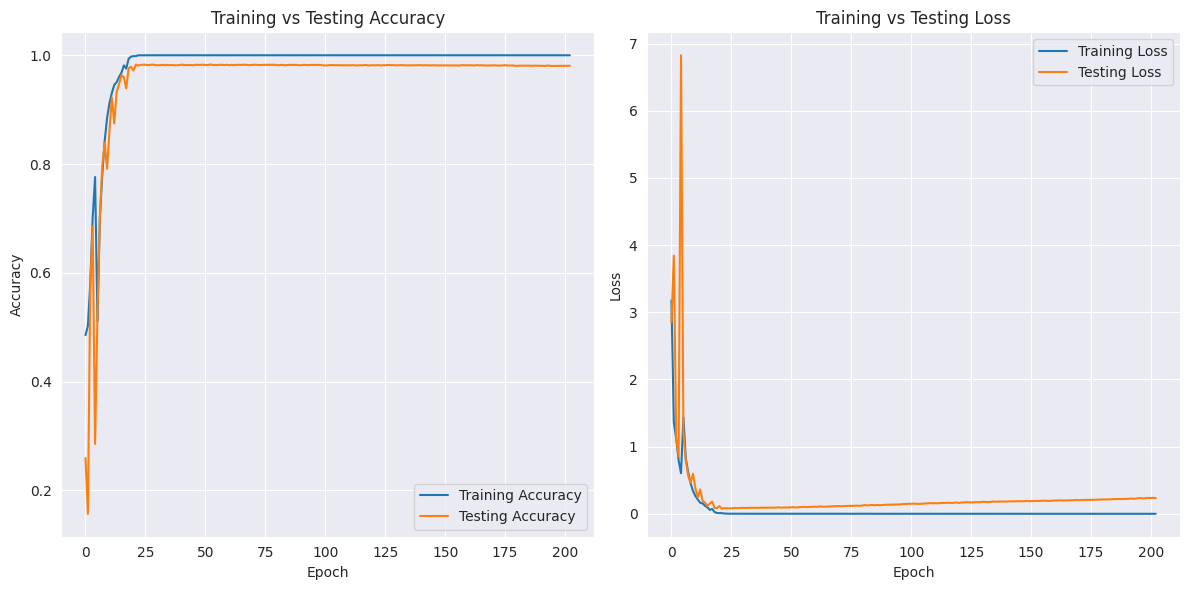

In [24]:
plot_accuracy_and_loss(history)

In [25]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'
    
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout
    plt.show()

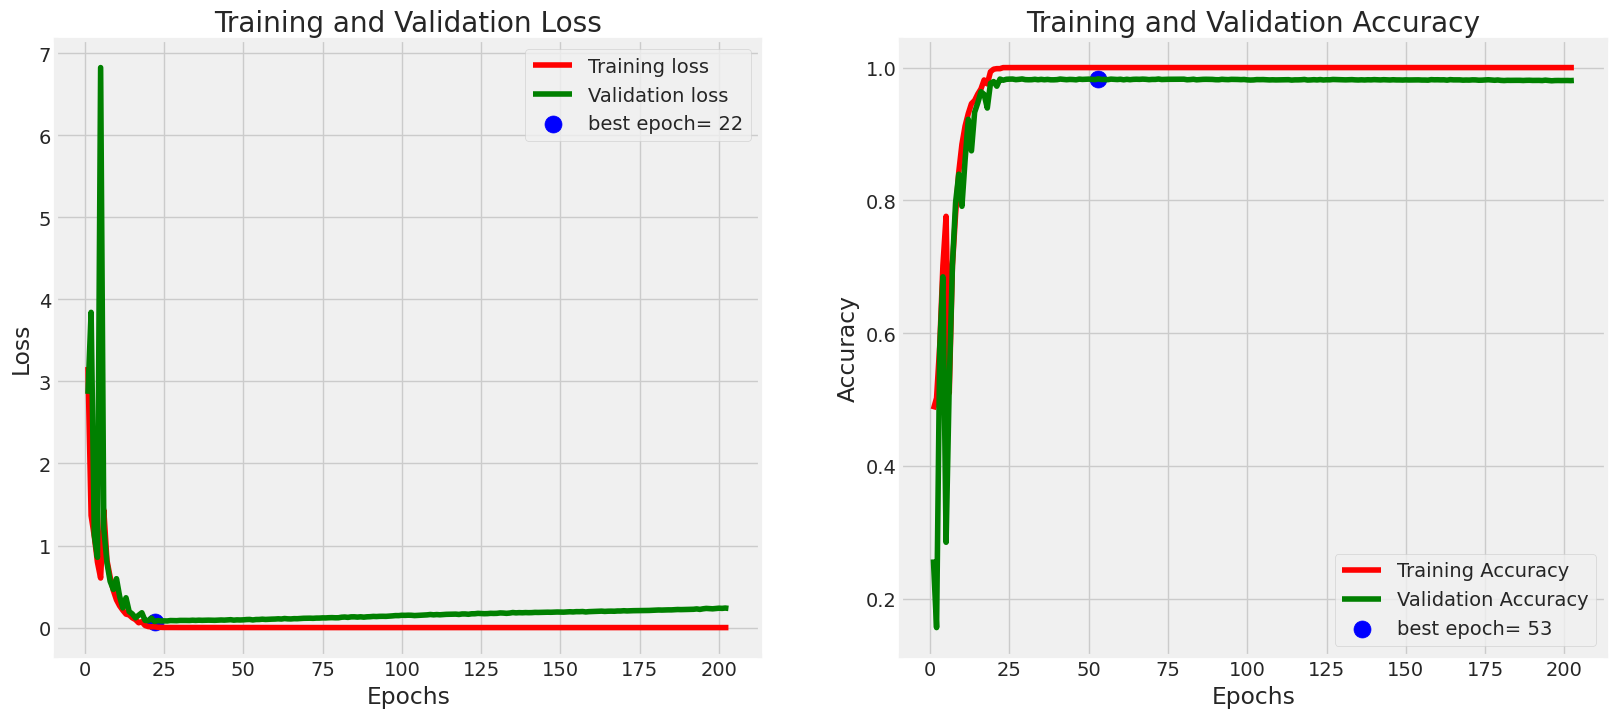

In [26]:
plot_training(history)

In [27]:
train_score = model.evaluate(X_train, y_train, verbose= 1)
test_score = model.evaluate(X_test, y_test, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

2023-12-24 17:11:31.762740: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 662342016 exceeds 10% of free system memory.
2023-12-24 17:11:32.307762: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 662342016 exceeds 10% of free system memory.


367/367 [==============================] - 2s 6ms/step - loss: 0.2286 - accuracy: 0.9806
Train Loss:  1.247259451275795e-08
Train Accuracy:  1.0
--------------------
Test Loss:  0.22863343358039856
Test Accuracy:  0.9805693030357361


In [28]:
y_true = np.array(y_test)
y_pred = model.predict(X_test)

y_pred = np.argmax(y_pred , axis=1)
y_true = np.argmax(y_true , axis=1)

367/367 [==============================] - 2s 5ms/step


# Plot ROC , Recall , Precision , Sensitivity , Specificity , F1 Score , Precision-Recall with average value

367/367 [==============================] - 2s 5ms/step


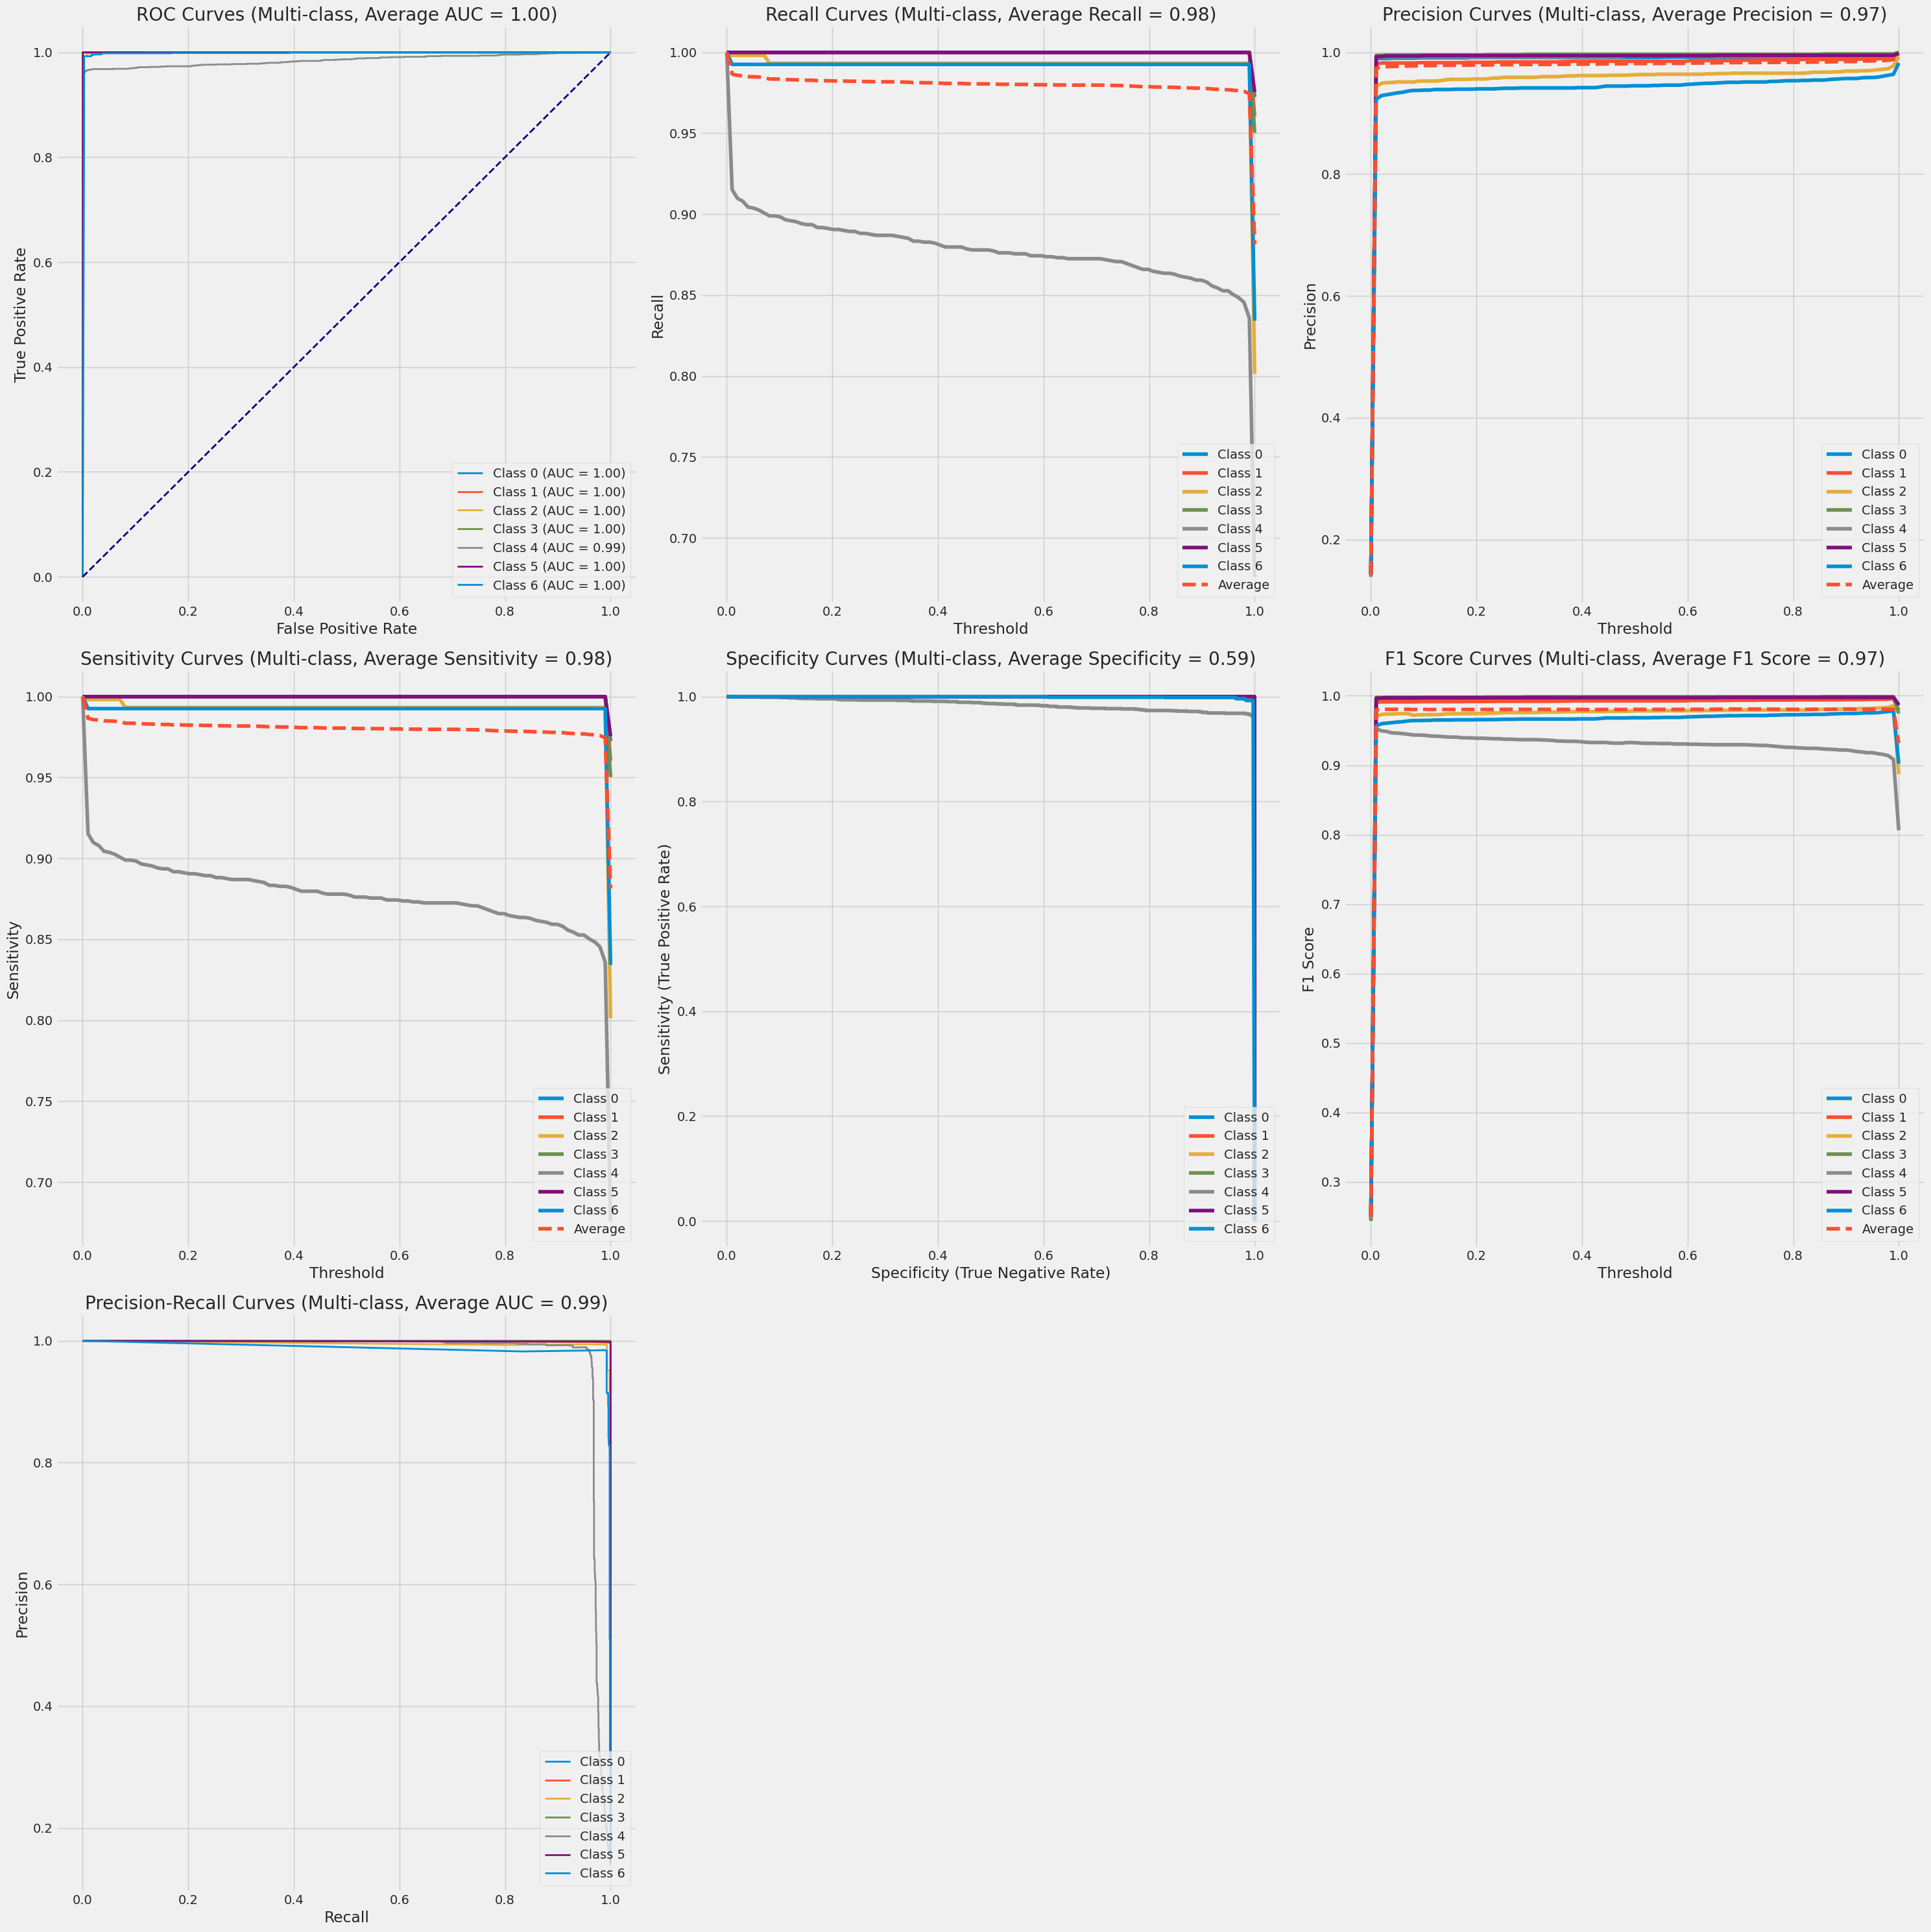

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc, recall_score, precision_score, f1_score, precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize

def plot_curves(y_true, y_scores):
    num_classes = y_scores.shape[1]
    
    # Binarize the labels
    y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))
    
    # Initialize figure
    plt.figure(figsize=(30, 30))
    
    # Plot ROC curve for each class
    plt.subplot(3, 3, 1)
    avg_auc = 0
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
        roc_auc = auc(fpr, tpr)
        avg_auc += roc_auc
        plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')
    avg_auc /= num_classes
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves (Multi-class, Average AUC = {avg_auc:.2f})')
    plt.legend(loc="lower right")
    
    # Plot Recall curve for each class
    plt.subplot(3, 3, 2)
    avg_recall = 0
    recall_values_avg = []
    for i in range(num_classes):
        recall_values = [recall_score(y_true_bin[:, i], (y_scores[:, i] >= threshold).astype(int)) for threshold in np.linspace(0, 1, 100)]
        avg_recall += np.mean(recall_values)
        recall_values_avg.append(recall_values)
        plt.plot(np.linspace(0, 1, 100), recall_values, label=f'Class {i}')
    avg_recall /= num_classes
    plt.plot(np.linspace(0, 1, 100), np.mean(recall_values_avg, axis=0), label='Average', linestyle='--')
    plt.xlabel('Threshold')
    plt.ylabel('Recall')
    plt.title(f'Recall Curves (Multi-class, Average Recall = {avg_recall:.2f})')
    plt.legend(loc="lower right")

    # Plot Precision curve for each class
    plt.subplot(3, 3, 3)
    avg_precision = 0
    precision_values_avg = []
    for i in range(num_classes):
        precision_values = [precision_score(y_true_bin[:, i], (y_scores[:, i] >= threshold).astype(int)) for threshold in np.linspace(0, 1, 100)]
        avg_precision += np.mean(precision_values)
        precision_values_avg.append(precision_values)
        plt.plot(np.linspace(0, 1, 100), precision_values, label=f'Class {i}')
    avg_precision /= num_classes
    plt.plot(np.linspace(0, 1, 100), np.mean(precision_values_avg, axis=0), label='Average', linestyle='--')
    plt.xlabel('Threshold')
    plt.ylabel('Precision')
    plt.title(f'Precision Curves (Multi-class, Average Precision = {avg_precision:.2f})')
    plt.legend(loc="lower right")

    # Plot Sensitivity curve for each class
    plt.subplot(3, 3, 4)
    avg_sensitivity = 0
    sensitivity_values_avg = []
    for i in range(num_classes):
        sensitivity_values = [recall_score(y_true_bin[:, i], (y_scores[:, i] >= threshold).astype(int)) for threshold in np.linspace(0, 1, 100)]
        avg_sensitivity += np.mean(sensitivity_values)
        sensitivity_values_avg.append(sensitivity_values)
        plt.plot(np.linspace(0, 1, 100), sensitivity_values, label=f'Class {i}')
    avg_sensitivity /= num_classes
    plt.plot(np.linspace(0, 1, 100), np.mean(sensitivity_values_avg, axis=0), label='Average', linestyle='--')
    plt.xlabel('Threshold')
    plt.ylabel('Sensitivity')
    plt.title(f'Sensitivity Curves (Multi-class, Average Sensitivity = {avg_sensitivity:.2f})')
    plt.legend(loc="lower right")

    # Plot Specificity curve for each class
    plt.subplot(3, 3, 5)
    avg_specificity = 0
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
        tnr = 1 - fpr
        avg_specificity += np.mean(tnr)
        plt.plot(tnr, tpr, label=f'Class {i}')
    avg_specificity /= num_classes
    plt.xlabel('Specificity (True Negative Rate)')
    plt.ylabel('Sensitivity (True Positive Rate)')
    plt.title(f'Specificity Curves (Multi-class, Average Specificity = {avg_specificity:.2f})')
    plt.legend(loc='lower right')

    # Plot F1 Score curve for each class
    plt.subplot(3, 3, 6)
    avg_f1 = 0
    f1_values_avg = []
    for i in range(num_classes):
        f1_values = [f1_score(y_true_bin[:, i], (y_scores[:, i] >= threshold).astype(int)) for threshold in np.linspace(0, 1, 100)]
        avg_f1 += np.mean(f1_values)
        f1_values_avg.append(f1_values)
        plt.plot(np.linspace(0, 1, 100), f1_values, label=f'Class {i}')
    avg_f1 /= num_classes
    plt.plot(np.linspace(0, 1, 100), np.mean(f1_values_avg, axis=0), label='Average', linestyle='--')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.title(f'F1 Score Curves (Multi-class, Average F1 Score = {avg_f1:.2f})')
    plt.legend(loc="lower right")

    # Plot Precision-Recall curve for each class
    plt.subplot(3, 3, 7)
    avg_precision_recall = 0
    for i in range(num_classes):
        precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_scores[:, i])
        avg_precision_recall += auc(recall, precision)
        plt.plot(recall, precision, lw=2, label=f'Class {i}')
    avg_precision_recall /= num_classes
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curves (Multi-class, Average AUC = {avg_precision_recall:.2f})')
    plt.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

y_pred_probs = model.predict(X_test)
# Assuming y_pred_probs contains probabilities for each class
plot_curves(y_true, y_pred_probs)


# Plot ROC , Recall , Precision , Sensitivity , Specificity , F1 Score , Precision-Recall with mean value

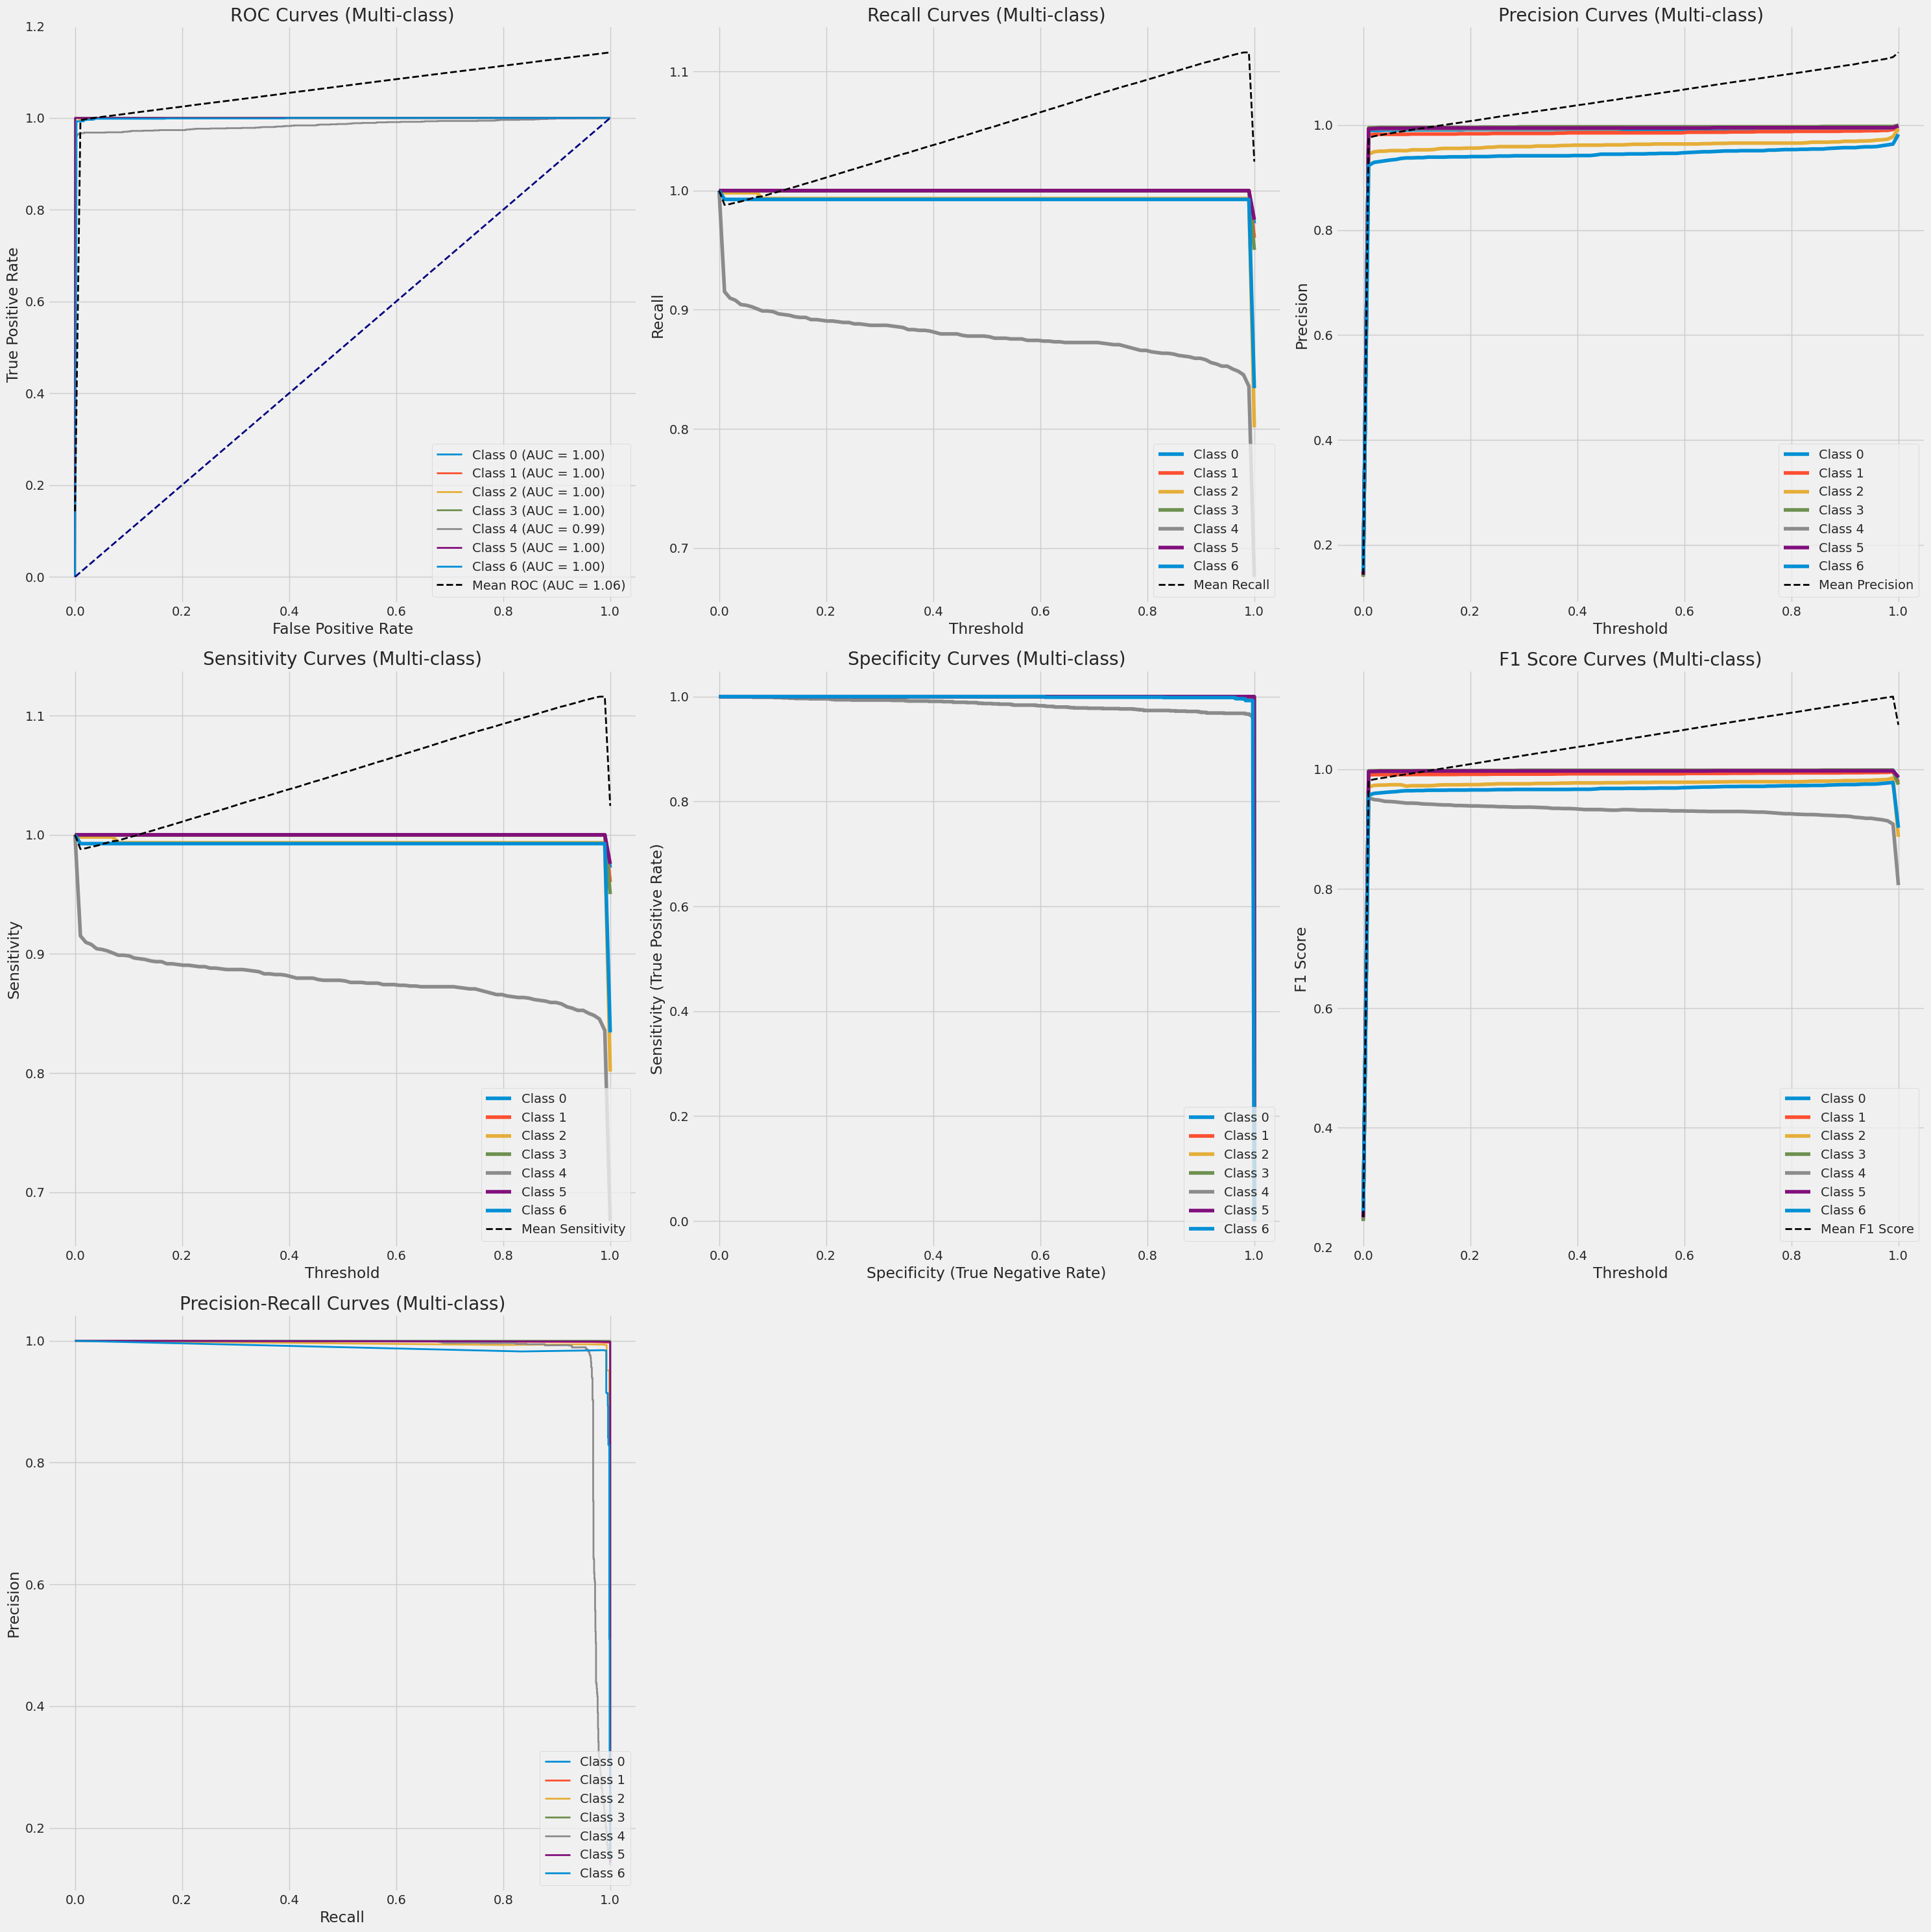

In [30]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc, recall_score, precision_score, f1_score, precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize

def plot_curves2(y_true, y_scores):
    num_classes = y_scores.shape[1]
    
    # Binarize the labels
    y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))
    
    # Initialize figure
    plt.figure(figsize=(30, 30))
    
    # Lists to store mean values
    mean_fpr, mean_tpr = np.linspace(0, 1, 100), np.linspace(0, 1, 100)
    mean_recall, mean_precision = np.linspace(0, 1, 100), np.linspace(0, 1, 100)
    mean_sensitivity, mean_f1 = np.linspace(0, 1, 100), np.linspace(0, 1, 100)
    
    # Plot ROC curve for each class
    plt.subplot(3, 3, 1)
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')
        mean_tpr += np.interp(mean_fpr, fpr, tpr)
    mean_tpr /= num_classes
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='black', linestyle='--', lw=2, label=f'Mean ROC (AUC = {mean_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves (Multi-class)')
    plt.legend(loc="lower right")
    
    # Plot Recall curve for each class
    plt.subplot(3, 3, 2)
    for i in range(num_classes):
        recall_values = [recall_score(y_true_bin[:, i], (y_scores[:, i] >= threshold).astype(int)) for threshold in np.linspace(0, 1, 100)]
        plt.plot(np.linspace(0, 1, 100), recall_values, label=f'Class {i}')
        mean_recall += np.interp(np.linspace(0, 1, 100), np.linspace(0, 1, 100), recall_values)
    mean_recall /= num_classes
    plt.plot(np.linspace(0, 1, 100), mean_recall, color='black', linestyle='--', lw=2, label='Mean Recall')
    plt.xlabel('Threshold')
    plt.ylabel('Recall')
    plt.title('Recall Curves (Multi-class)')
    plt.legend(loc="lower right")

    # Plot Precision curve for each class
    plt.subplot(3, 3, 3)
    for i in range(num_classes):
        precision_values = [precision_score(y_true_bin[:, i], (y_scores[:, i] >= threshold).astype(int)) for threshold in np.linspace(0, 1, 100)]
        plt.plot(np.linspace(0, 1, 100), precision_values, label=f'Class {i}')
        mean_precision += np.interp(np.linspace(0, 1, 100), np.linspace(0, 1, 100), precision_values)
    mean_precision /= num_classes
    plt.plot(np.linspace(0, 1, 100), mean_precision, color='black', linestyle='--', lw=2, label='Mean Precision')
    plt.xlabel('Threshold')
    plt.ylabel('Precision')
    plt.title('Precision Curves (Multi-class)')
    plt.legend(loc="lower right")

    # Plot Sensitivity curve for each class
    plt.subplot(3, 3, 4)
    for i in range(num_classes):
        sensitivity_values = [recall_score(y_true_bin[:, i], (y_scores[:, i] >= threshold).astype(int)) for threshold in np.linspace(0, 1, 100)]
        plt.plot(np.linspace(0, 1, 100), sensitivity_values, label=f'Class {i}')
        mean_sensitivity += np.interp(np.linspace(0, 1, 100), np.linspace(0, 1, 100), sensitivity_values)
    mean_sensitivity /= num_classes
    plt.plot(np.linspace(0, 1, 100), mean_sensitivity, color='black', linestyle='--', lw=2, label='Mean Sensitivity')
    plt.xlabel('Threshold')
    plt.ylabel('Sensitivity')
    plt.title('Sensitivity Curves (Multi-class)')
    plt.legend(loc="lower right")

    # Plot Specificity curve for each class
    plt.subplot(3, 3, 5)
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
        tnr = 1 - fpr
        plt.plot(tnr, tpr, label=f'Class {i}')
    plt.xlabel('Specificity (True Negative Rate)')
    plt.ylabel('Sensitivity (True Positive Rate)')
    plt.title('Specificity Curves (Multi-class)')
    plt.legend(loc='lower right')

    # Plot F1 Score curve for each class
    plt.subplot(3, 3, 6)
    for i in range(num_classes):
        f1_values = [f1_score(y_true_bin[:, i], (y_scores[:, i] >= threshold).astype(int)) for threshold in np.linspace(0, 1, 100)]
        plt.plot(np.linspace(0, 1, 100), f1_values, label=f'Class {i}')
        mean_f1 += np.interp(np.linspace(0, 1, 100), np.linspace(0, 1, 100), f1_values)
    mean_f1 /= num_classes
    plt.plot(np.linspace(0, 1, 100), mean_f1, color='black', linestyle='--', lw=2, label='Mean F1 Score')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.title('F1 Score Curves (Multi-class)')
    plt.legend(loc="lower right")

    # Plot Precision-Recall curve for each class
    plt.subplot(3, 3, 7)
    for i in range(num_classes):
        precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_scores[:, i])
        plt.plot(recall, precision, lw=2, label=f'Class {i}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves (Multi-class)')
    plt.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

# Assuming y_pred

plot_curves2(y_true, y_pred_probs)

# Plot Confusion Matrix

In [31]:
classes_labels = []
for key in classes.keys():
    classes_labels.append(key)

print(classes_labels)

[4, 6, 2, 1, 5, 0, 3]


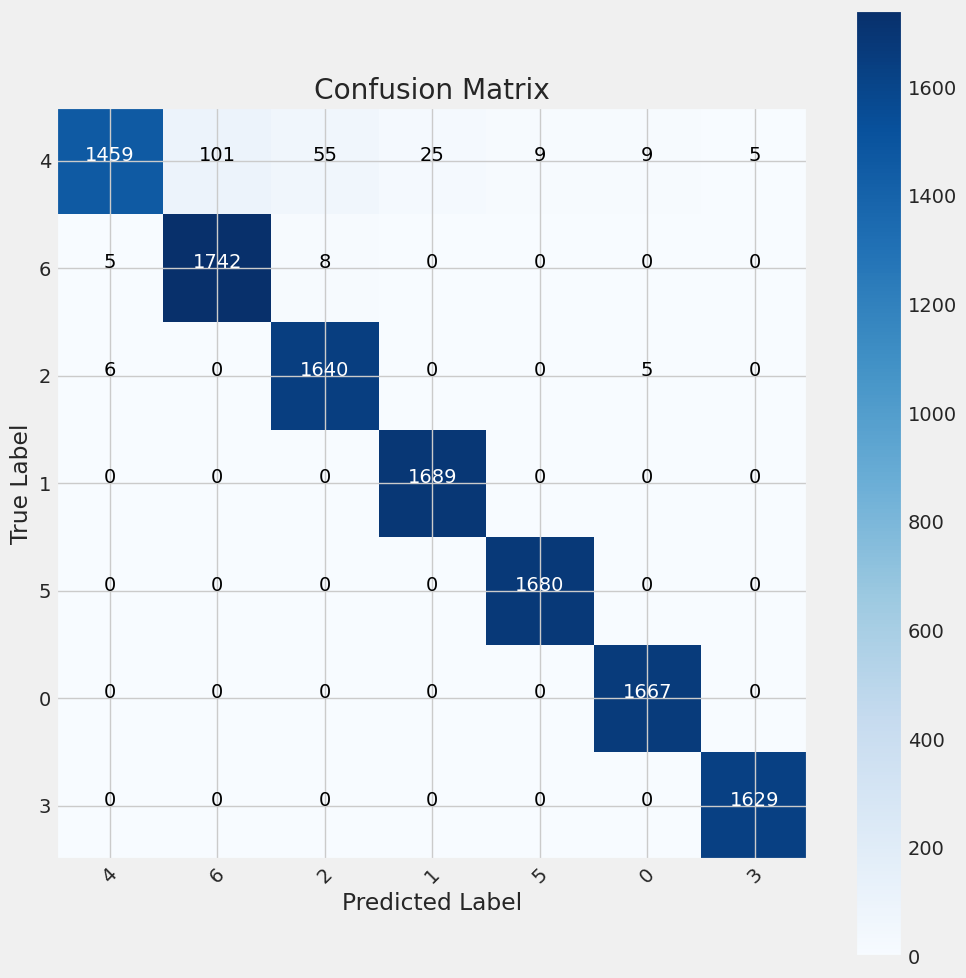

In [32]:
cm = cm = confusion_matrix(y_true, y_pred, labels=classes_labels)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

# Store the Weights

In [36]:
# import tensorflow as tf
# model.save_weights('model_weights/AttentionInceptionNet.h5')

# Clear the session

In [34]:
# from keras import backend as K
# import gc

# del model

# K.clear_session()
# gc.collect()

In [35]:
# #You need to install numba using 'pip install numba'

# from numba import cuda

# cuda.select_device(0)
# cuda.close()